## Creating helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-04-15 14:58:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-15 14:58:12 (69.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2025-04-15 14:58:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.207, 74.125.69.207, 64.233.181.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   133MB/s    in 15s     

2025-04-15 14:58:32 (105 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/scallops'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '10

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth, Resizing, Rescaling
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    # Resizing(224, 224),
    # Rescaling(1./255)
], name="data_augmentation")

In [9]:
# Setup the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [12]:
history = model.fit(train_data_all_10_percent,
                    epochs=1,  # 5
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[
                        #create_tensorboard_callback("training_logs", "101_classes_10_percent_data_model"),
                               checkpoint_callback])

237/237 ━━━━━━━━━━━━━━━━━━━━ 997s 4s/step - accuracy: 0.1614 - loss: 3.9560 - val_accuracy: 0.4693 - val_loss: 2.4735


In [13]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 2077s 3s/step - accuracy: 0.4782 - loss: 2.3741


[2.333308219909668, 0.4747326672077179]

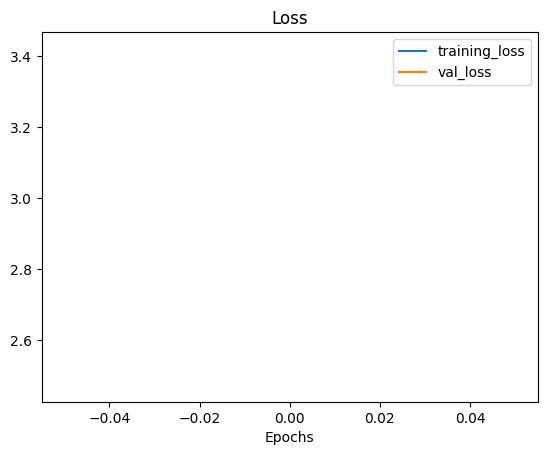

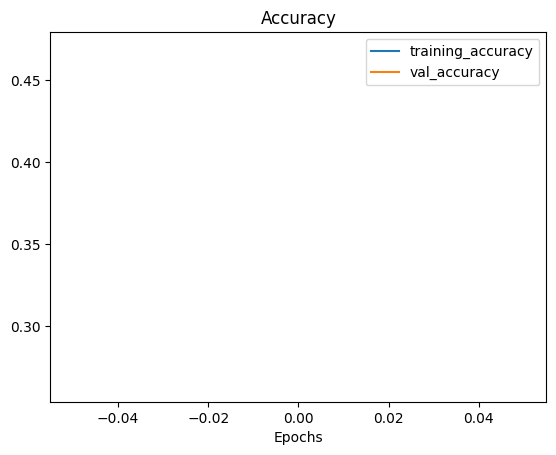

In [14]:
plot_loss_curves(history)

## Fine tuning

In [15]:
# unfreeze all layers of base model
base_model.trainable = True

# Refreeze every layer except last 5 layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [16]:
# recompile with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [17]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [18]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [19]:
fine_tune_epochs = 2  # 10
history_fine_tune = model.fit(train_data_all_10_percent,
                    epochs=fine_tune_epochs,
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    # callbacks=[
                        #create_tensorboard_callback("training_logs", "101_classes_10_percent_data_model"),
                              #  checkpoint_callback]
                    initial_epoch=history.epoch[-1]
                              )

Epoch 1/2
237/237 ━━━━━━━━━━━━━━━━━━━━ 1063s 4s/step - accuracy: 0.4767 - loss: 2.4540 - val_accuracy: 0.5101 - val_loss: 2.0637
Epoch 2/2
237/237 ━━━━━━━━━━━━━━━━━━━━ 1100s 5s/step - accuracy: 0.5468 - loss: 2.0421 - val_accuracy: 0.5373 - val_loss: 1.8794


In [20]:
fine_tuning_results_2 = model.evaluate(test_data)
fine_tuning_results_2

790/790 ━━━━━━━━━━━━━━━━━━━━ 2097s 3s/step - accuracy: 0.5397 - loss: 1.8195


[1.7490497827529907, 0.5526732802391052]

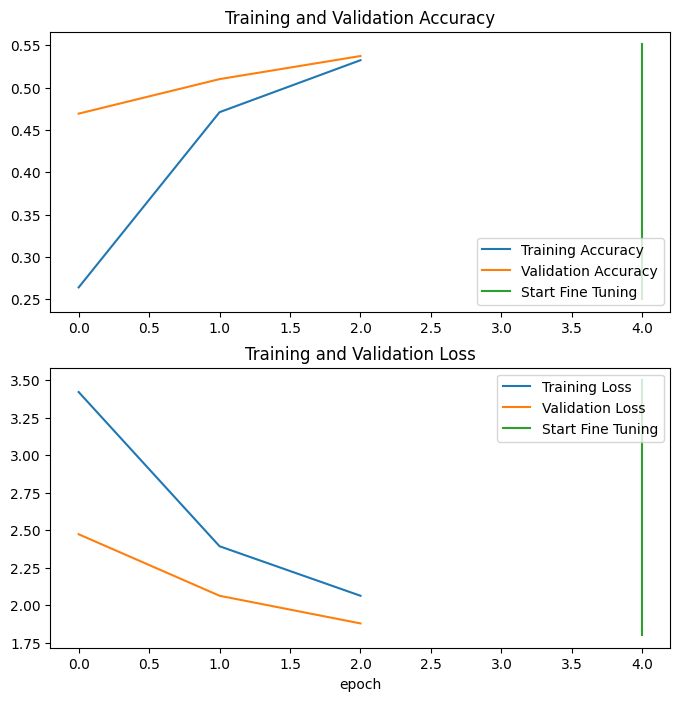

In [21]:
compare_historys(history, history_fine_tune)

In [22]:
model.save("/content/drive/MyDrive/TensorFlow/101_food_classes_10_Percent.keras")

In [23]:
# load and evaluate saved mocel
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/TensorFlow/101_food_classes_10_Percent.keras")

In [24]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 2095s 3s/step - accuracy: 0.5397 - loss: 1.8195


[1.7490497827529907, 0.5526732802391052]

In [25]:
# Lets make predictions
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

--2025-04-15 17:37:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.189.207, 142.250.152.207, 108.177.121.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.189.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  96.9MB/s    in 0.5s    

2025-04-15 17:37:26 (96.9 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [26]:
preda_probs = loaded_model.predict(test_data, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 2147s 3s/step


In [27]:
len(preda_probs)

25250

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import TFSMLayer
import numpy as np

# Path to your SavedModel -- this is my OWN path, replace with YOUR path
model_path = '/content/06_101_food_class_10_percent_saved_big_dog_model'

# Create a TFSMLayer instance with the correct endpoint
loaded_new_model = TFSMLayer(model_path, call_endpoint='serving_default')

# Initialize lists to collect predictions and labels
all_predictions = []
all_labels = []

# Iterate through the dataset
for batch_data, batch_labels in test_data:  # test_data should be a tf.data.Dataset
    # Convert to tensors if not already
    batch_data_tensor = tf.convert_to_tensor(batch_data)
    batch_labels_tensor = tf.convert_to_tensor(batch_labels)

    # Make predictions for the batch
    batch_predictions = loaded_new_model(batch_data_tensor)

    # Extract the tensor from the dictionary using the correct key
    batch_predictions_tensor = batch_predictions['dense_8']

    # Collect the predictions and labels
    all_predictions.append(batch_predictions_tensor)
    all_labels.append(batch_labels_tensor)

# Concatenate all predictions and labels
all_predictions = tf.concat(all_predictions, axis=0)
all_labels = tf.concat(all_labels, axis=0)

# Check shapes of predictions and labels
print(f'All Predictions shape: {all_predictions.shape}')
print(f'All Labels shape: {all_labels.shape}')

# Ensure the labels are in the correct shape (one-hot encoding)
if len(all_labels.shape) == 1 or all_labels.shape[1] == 1:
    all_labels = tf.one_hot(all_labels, depth=all_predictions.shape[-1])

# Evaluate the predictions
accuracy = np.mean(np.argmax(all_predictions, axis=1) == np.argmax(all_labels, axis=1))
print(f'Accuracy: {accuracy}')

All Predictions shape: (25250, 101)
All Labels shape: (25250, 101)
Accuracy: 0.6077623762376237
